<a href="https://colab.research.google.com/github/olonok69/LLM_Notebooks/blob/main/LLMOps/L2_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### LLMOPs training Course . Vertex Ai and Kubeflow

In [ ]:
!pip install google-cloud-aiplatform

#### utils.py and requirements.txt to the same folder

In [ ]:
## utils.py

# import os
# from dotenv import load_dotenv
# import json
# import base64
# from google.auth.transport.requests import Request
# from google.oauth2.service_account import Credentials

# def authenticate():
#     return "DLAI_CREDENTIALS", "DLAI_PROJECT_ID"
#     #Load .env
#     load_dotenv()

#     #Decode key and store in .JSON
#     SERVICE_ACCOUNT_KEY_STRING_B64 = os.getenv('SERVICE_ACCOUNT_KEY')
#     SERVICE_ACCOUNT_KEY_BYTES_B64 = SERVICE_ACCOUNT_KEY_STRING_B64.encode("ascii")
#     SERVICE_ACCOUNT_KEY_STRING_BYTES = base64.b64decode(SERVICE_ACCOUNT_KEY_BYTES_B64)
#     SERVICE_ACCOUNT_KEY_STRING = SERVICE_ACCOUNT_KEY_STRING_BYTES.decode("ascii")

#     SERVICE_ACCOUNT_KEY = json.loads(SERVICE_ACCOUNT_KEY_STRING)


#     # Create credentials based on key from service account
#     # Make sure your account has the roles listed in the Google Cloud Setup section
#     credentials = Credentials.from_service_account_info(
#         SERVICE_ACCOUNT_KEY,
#         scopes=['https://www.googleapis.com/auth/cloud-platform'])

#     if credentials.expired:
#         credentials.refresh(Request())

#     #Set project ID according to environment variable
#     PROJECT_ID = os.getenv('PROJECT_ID')

#     return credentials, PROJECT_ID

In [ ]:
#requirements.txt
# requirements file
# note which revision of python, for example 3.9.6
# in this file, insert all the pip install needs, include revision

# google-ai-generativelanguage==0.2.0
# google-api-core==2.11.0
# google-api-python-client==2.94.0
# google-auth==2.22.0
# google-auth-httplib2==0.1.0
# google-auth-oauthlib
# google-cloud-aiplatform==1.39.0
# google-cloud-bigquery==3.11.0
# google-cloud-core==2.3.2
# google-cloud-resource-manager==1.10.1
# google-cloud-storage==2.9.0
# google-crc32c==1.5.0
# google-generativeai==0.1.0
# google-resumable-media==2.5.0
# googleapis-common-protos==1.59.0
# kfp==2.4.0
# vertexai==0.0.1
# python-dotenv==1.0.0
# scikit-learn==1.2.2
# mplcursors==0.5.2
# ipympl==0.9.3
# tqdm==4.65.0
# protobuf==3.19.6
# ipython==8.14.0
# pandas==2.0.2
# pyarrow==12.0.1

# L2: Data Exploration for Tuning a Foundation Model

**Project environment setup:**

- Load credentials and relevant Python Libraries
- If you were running this notebook locally, you would first install Vertex AI. In this classroom, this is already installed.

```
!pip install google-cloud-aiplatform
```
- You can download the `requirements.txt` for this course from the workspace of this lab. `File --> Open...`

In [ ]:
from utils import authenticate
credentials, PROJECT_ID = authenticate()

REGION = "us-central1"

- Import the [Vertex AI](https://cloud.google.com/vertex-ai) SDK.
- The library helps to interact with the Vertex AI services in the cloud.
- Initialize it.

In [ ]:
import vertexai
vertexai.init(project = PROJECT_ID,
              location = REGION,
              credentials = credentials)

- Import [BigQuery](https://cloud.google.com/bigquery) to use as your data warehouse.
- Initialize the client to start interacting with the data warehouse, send SQL and retrieve data into the notebook.

In [ ]:
from google.cloud import bigquery
bq_client = bigquery.Client(project=PROJECT_ID,
                            credentials = credentials)

## Stack Overflow Public Dataset

- You will use [Stack Overflow Data](https://cloud.google.com/blog/topics/public-datasets/google-bigquery-public-datasets-now-include-stack-overflow-q-a) on BigQuery Public Datasets.
- The datasets include questions, answers and metadata related to Stack Overflow questions. Within this dataset, there are tables with data.
- Create a SQL query.

In [ ]:
QUERY_TABLES = """
SELECT
  table_name
FROM
  `bigquery-public-data.stackoverflow.INFORMATION_SCHEMA.TABLES`
"""

- The query is asking to retrieve `table_name` of all the `TABLES`
- Use the client to send your SQL and retrieve the data (tables names).

In [ ]:
query_job = bq_client.query(QUERY_TABLES)
for row in query_job:
    for value in row.values():
        print(value)


"""
posts_answers
users
posts_orphaned_tag_wiki
posts_tag_wiki
stackoverflow_posts
posts_questions
comments
posts_tag_wiki_excerpt
posts_wiki_placeholder
posts_privilege_wiki
post_history
badges
post_links
tags
votes
posts_moderator_nomination
"""

## Data Retrieval
- You'll fetch some data from the data warehouse and store it in Pandas dataframe for visualization.
- Select all columns from  `posts_questions` and put the `LIMIT` as 3.

In [ ]:
INSPECT_QUERY = """
SELECT
    *
FROM
    `bigquery-public-data.stackoverflow.posts_questions`
LIMIT 3
"""
import pandas as pd
query_job = bq_client.query(INSPECT_QUERY)

- Take the results of the query `-->` create an arrow table (which is part of [Apache Framework](https://arrow.apache.org/docs/index.html)) `-->` which goes into a Pandas dataframe.
- This allows for data to be in a format which is easier to read and explore with Pandas.

In [ ]:
stack_overflow_df = query_job\
    .result()\
    .to_arrow()\
    .to_pandas()
stack_overflow_df.head()

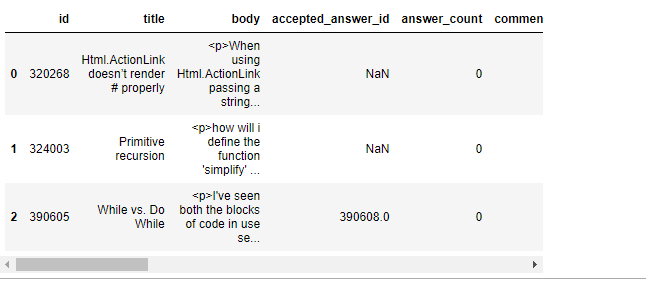

### Dealing with Large Datasets

- Large datasets for LLMs often don't fit into memory.
- Select all of the columns and rows of the table `posts_questions`.

In [ ]:
QUERY_ALL = """
SELECT
    *
FROM
    `bigquery-public-data.stackoverflow.posts_questions` q
"""

query_job = bq_client.query(QUERY_ALL)

try:
    stack_overflow_df = query_job\
    .result()\
    .to_arrow()\
    .to_pandas()
except Exception as e:
    print('The DataFrame is too large to load into memory.', e)


## **Note:** The data is too large to return, as it is not fitting into memory.

The DataFrame is too large to load into memory. 403 Response too large to return. Consider specifying a destination table in your job configuration. For more details, see https://cloud.google.com/bigquery/troubleshooting-errors

Location: US
Job ID: bbd2aaa7-6abc-4351-8201-acb181342fab

**Joining Tables and Query Optimization**

- When working with (large) data, query optimizing is needed in order to save time and resources.
- Select questions as input_text (column 1), answers as output_text (column 2).
- Take the questions from posts_questions and answers from posts_answers.
- Join the questions and their corresponding accepted answers based on their same unique ID.
- Making sure the question is about Python, and that it has an answer. And the date the question was posted is on or after 2020-01-01
- Limit as 10,000




In [ ]:
QUERY = """
SELECT
    CONCAT(q.title, q.body) as input_text,
    a.body AS output_text
FROM
    `bigquery-public-data.stackoverflow.posts_questions` q
JOIN
    `bigquery-public-data.stackoverflow.posts_answers` a
ON
    q.accepted_answer_id = a.id
WHERE
    q.accepted_answer_id IS NOT NULL AND
    REGEXP_CONTAINS(q.tags, "python") AND
    a.creation_date >= "2020-01-01"
LIMIT
    10000
"""
query_job = bq_client.query(QUERY)

### this may take some seconds to run
stack_overflow_df = query_job.result()\
                        .to_arrow()\
                        .to_pandas()

stack_overflow_df.head(2)

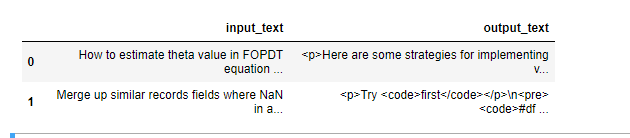

### Adding Instructions

- Instructions for LLMs have been shown to improve
model performance and generalization to unseen tasks [(Google, 2022)](https://arxiv.org/pdf/2210.11416.pdf).
- Wihtout the instruction, it is only question and answer. Model might not understand what to do.
- With the instructions, the model gets a guideline as to what task to perform.

In [ ]:
INSTRUCTION_TEMPLATE = f"""\
Please answer the following Stackoverflow question on Python. \
Answer it like you are a developer answering Stackoverflow questions.

Stackoverflow question:
"""
# A new column will combine `INSTRUCTION_TEMPLATE` and the question `input_text`.
# This avoids overwritting of any existing column which might be needed.

stack_overflow_df['input_text_instruct'] = INSTRUCTION_TEMPLATE + ' '\
    + stack_overflow_df['input_text']

### Dataset for Tuning

- Divide the data into a training and evaluation. By default, 80/20 split is used.
- This (80/20 split) allows for more data to be used for tuning. The evaluation split is used as unseen data during tuning to evaluate performance.
- The `random_state` parameter is used to ensure random sampling for a fair comparison.

In [ ]:
from sklearn.model_selection import train_test_split

train, evaluation = train_test_split(
    stack_overflow_df,
    ### test_size=0.2 means 20% for evaluation
    ### which then makes train set to be of 80%
    test_size=0.2,
    random_state=42
)


#### Different Datasets and Flow

- Versioning data is important.
- It allows for reproducibility, traceability, and maintainability of machine learning models.
- Get the timestamp.

In [ ]:
import datetime
date = datetime.datetime.now().strftime("%H:%d:%m:%Y")

- Generate a `jsonl` file.
- Name it as `tune_data_stack_overflow_python_qa-{date}`

In [ ]:
cols = ['input_text_instruct','output_text']
tune_jsonl = train[cols].to_json(orient="records", lines=True)

training_data_filename = f"tune_data_stack_overflow_\
                            python_qa-{date}.jsonl"

with open(training_data_filename, "w") as f:
    f.write(tune_jsonl)

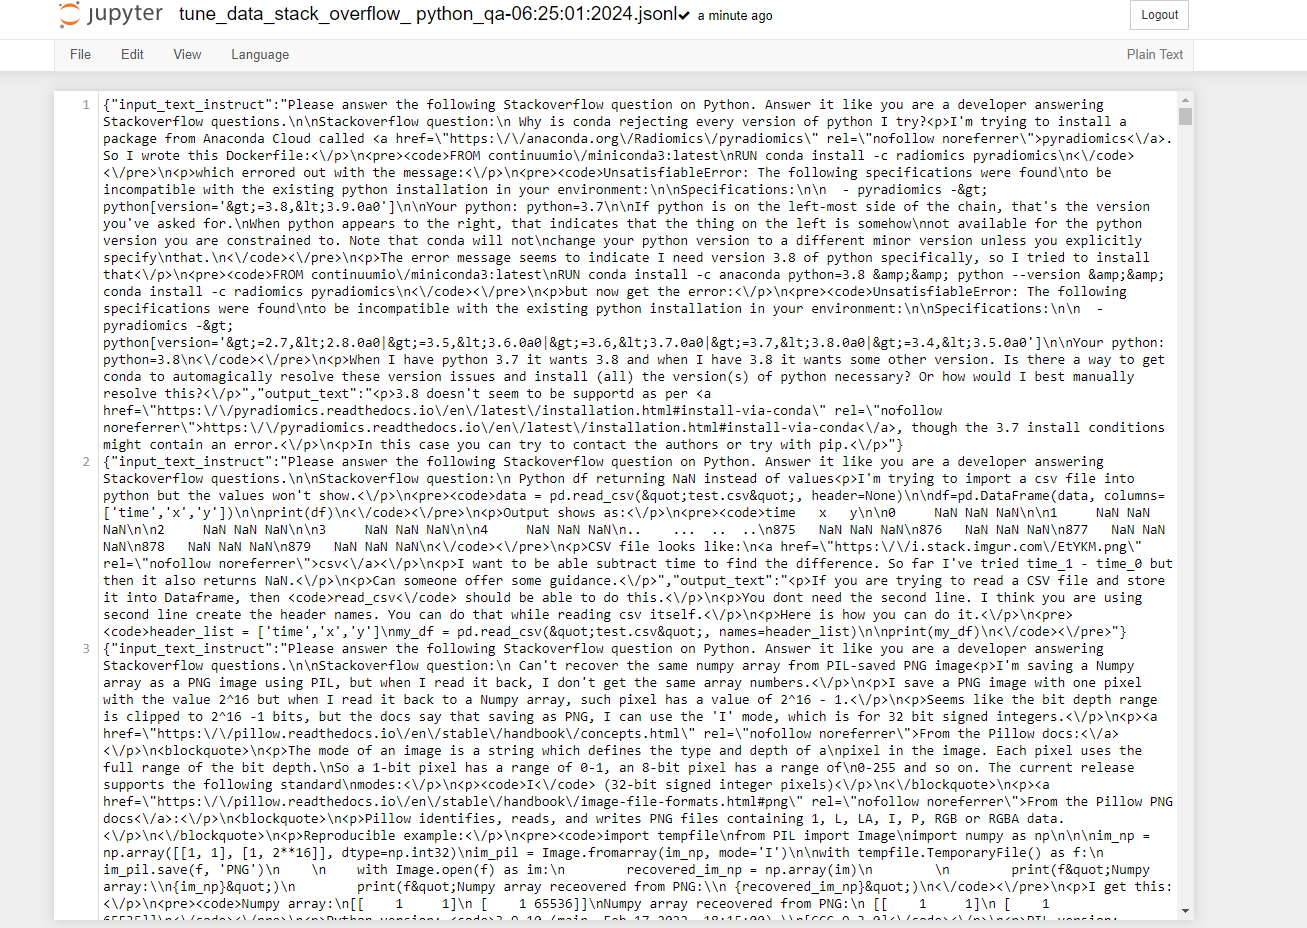